In [1]:
import keras
import numpy as np
from keras.layers import Input,Dense, Layer, Add, Multiply, Lambda
from keras.models import Model, Sequential
from keras import backend as K

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from numpy import linalg

Using TensorFlow backend.


In [110]:
def tpr95_tsne(X1, Y1):
    # X1(id) Y1(ood) score 1-0                                         
    start = 0.
    end = 10.
    gap = (end- start)/10000

    total = 0.0
    fpr = 0.0
    acc = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 <= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
  
        if tpr <= 0.96 and tpr >= 0.94:
            fpr += error2
            total += 1
            acc += delta
            #print(delta)
    
    fprBase = fpr/total
    delta = acc/total
    #print(delta)
    
    return fprBase

def tpr95(X1, Y1):
    # X1(id) Y1(ood) score 1-0                                         
    start = -200.
    end = 100.
    gap = (end- start)/100000

    total = 0.0
    fpr = 0.0
    acc = 0.0
    for delta in np.arange(start, end, .1):
        tpr = np.sum(np.sum(X1 <= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
  
        if tpr <= 0.9005 and tpr >= 0.8995:
            fpr += error2
            total += 1
            acc += delta
            #print(delta)
    
    fprBase = fpr/total
    delta = acc/total
    print(delta)
    
    return fprBase

def tpr95_(X1, Y1):
    # X1(id) Y1(ood) score 1-0                                         
    start = 0.1
    end = 1.
    gap = (end- start)/100000

    total = 0.0
    fpr = 0.0
    acc = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            fpr += error2
            total += 1
            acc += delta
    fprBase = fpr/total
    delta = acc/total
    print(delta)
    return fprBase

In [3]:
#------------------- read data (10000, 342)--------------------------------
x_test = np.load('data/pytorch/train_id_342_e.npy')
x_train = np.load('data/pytorch/test_id_342_e.npy')
data_ood = np.load('data/pytorch/test_ood_342_e.npy')
#--------------------------------------------------------------------------

In [9]:
#----------------- preprocessing ------------------------------------------

#--------------------------------------------------------------------------

In [4]:
original_dim = 342
intermediate_dim = 512
latent_dim = 10
batch_size = 128
epochs = 100
epsilon_std = 1.0

In [5]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

x = Input(shape=(original_dim,))
h = Dense(342, activation='relu')(x)#512
h = Dense(256, activation='relu')(h)#512
#h = Dense(512, activation='relu')(h)
#h = Dense(512, activation='relu')(h)
#h = Dense(512, activation='relu')(h)
h = Dense(256, activation='relu')(h)
h = Dense(128, activation='relu')(h)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# decoder
d = Dense(128,activation='relu')(z)
d = Dense(256,activation='relu')(d)
d = Dense(256,activation='relu')(d)
x_pred = Dense(original_dim, activation='sigmoid')(d)

#x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [10]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(data_ood[1:2],data_ood[1:2]))

Train on 10000 samples, validate on 1 samples
Epoch 1/10
10000/10000 [==============================] - 1s 142us/step - loss: -182.6671 - val_loss: 99.9844
Epoch 2/10
10000/10000 [==============================] - 1s 134us/step - loss: -182.7401 - val_loss: 86.8180
Epoch 3/10
10000/10000 [==============================] - 1s 139us/step - loss: -183.0115 - val_loss: 84.3764
Epoch 4/10
10000/10000 [==============================] - 1s 140us/step - loss: -183.2727 - val_loss: 78.5191
Epoch 5/10
10000/10000 [==============================] - 1s 144us/step - loss: -183.3961 - val_loss: 67.8234
Epoch 6/10
10000/10000 [==============================] - 2s 184us/step - loss: -184.4816 - val_loss: 73.3447
Epoch 7/10
10000/10000 [==============================] - 2s 164us/step - loss: -184.6448 - val_loss: 89.1009
Epoch 8/10
10000/10000 [==============================] - 2s 164us/step - loss: -184.9208 - val_loss: 71.1074
Epoch 9/10
10000/10000 [==============================] - 1s 146us/step - 

In [11]:
loss = nll(vae.input[0], vae.output)  # it has two inputs: x and e
f_loss = K.function([vae.input[0], K.learning_phase()], [loss])
f_z = K.function([vae.input[0], K.learning_phase()], [vae.layers[-5].output])

In [12]:
#------ computing reconstruction loss -----------------------------
aa = f_loss([x_train, 0])[0]
bb = f_loss([data_ood, 0])[0]
#------------------------------------------------------------------

In [13]:
mean = np.zeros(shape=(100,1000))
for i in range(100):
    mean[i,:] = f_loss([x_train[0:1000], 0])[0]
aa_p = np.mean(mean, axis=0)

print('Done!')
for i in range(100):
    mean[i,:] = f_loss([data_ood[0:1000], 0])[0]
bb_p = np.mean(mean, axis=0)

Done!


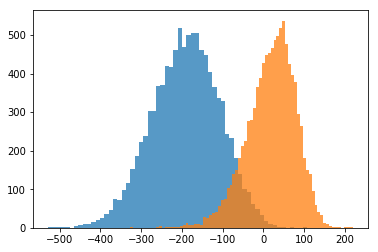

In [14]:
plt.hist(aa, bins='auto', alpha=0.75)
plt.hist(bb, bins='auto', alpha=0.75)
plt.show()

In [90]:
tpr95(aa,bb)*100

-86.35000000000646


5.065

In [91]:
idxs_bb = [i for i in range(len(bb)) if bb[i]<=-86.35]
idxs_aa = [i for i in range(len(aa)) if aa[i]>-86.35]

# t-sne

In [17]:
import time
import itertools
from sklearn.manifold import TSNE
from sklearn import mixture
import matplotlib as mpl

In [18]:
time_start = time.time()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(np.concatenate((x_train, data_ood), axis=0))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.595s...
[t-SNE] Computed neighbors for 20000 samples in 200.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

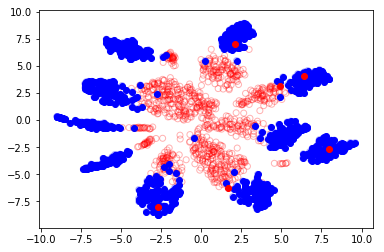

In [124]:
%matplotlib qt
T = 10000
fig, ax = plt.subplots()
ax.scatter(tsne_results[0:1000,0], tsne_results[0:1000,1], alpha=0.3,edgecolors='b',facecolors='none')
ax.scatter(tsne_results[10000:11000, 0], tsne_results[10000:11000, 1], alpha=0.3,edgecolors='r', facecolors='none')

for i in range(1000):
    if i not in idxs_aa:
        ax.scatter(tsne_results[i,0], tsne_results[i,1], color='b')
        
for i in range(1000):
    if i in idxs_bb:
        ax.scatter(tsne_results[10000+i,0], tsne_results[10000+i,1], color='r')

In [97]:
idxs_a_a = [i for i in range(10000) if i not in idxs_aa]
idxs_b_a = [i for i in range(10000) if i in idxs_bb]

idxs_a_a = np.asarray(idxs_a_a)
idxs_b_a = np.asarray(idxs_b_a) + 10000

tsne_data_id = np.concatenate((tsne_results[idxs_a_a], tsne_results[idxs_b_a]),axis=0)

In [98]:
gmm = mixture.GaussianMixture(n_components=10,covariance_type='full').fit(tsne_data_id)

In [99]:
aa_tsne = gmm.score_samples(tsne_results[0:10000])
bb_tsne = gmm.score_samples(tsne_results[10000:])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

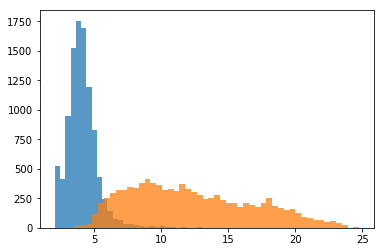

In [100]:
%matplotlib inline
plt.hist(-1.*aa_tsne, bins=50, alpha=0.75)
plt.hist(-1.*bb_tsne, bins=50, alpha=0.75)
plt.plot

In [101]:
tpr95_tsne(-1.*aa_tsne,-1.*bb_tsne)*100

5.8900000000000015


4.906620498614956

In [120]:
def tpr95_variable(X1, Y1, thres):
    # X1(id) Y1(ood) score 1-0                                         
    start = -400.
    end = 100.
    gap = (end- start)/100000

    total = 0.0
    fpr = 0.0
    acc = 0.0
    for delta in np.arange(start, end, .1):
        tpr = np.sum(np.sum(X1 <= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
  
        if tpr <= (thres+0.0005) and tpr >= (thres-0.0005):
            fpr += error2
            total += 1
            acc += delta
            #print(delta)
    
    fprBase = fpr/total
    delta = acc/total
    #print(delta)
    
    return delta

In [123]:
#---------------------- computing optimal threshold -----------------------------
for percent in np.arange(.20,.55, .01):
    thres = tpr95_variable(aa, bb, percent)  # aa, bb-> score loss of vae
    
    # for this thresh, view when fail the vae
    idxs_bb = [i for i in range(len(bb)) if bb[i]<=thres]
    idxs_aa = [i for i in range(len(aa)) if aa[i]>-thres]
    
    # in 2-D, select the points that vae classify like id, both x_train and data_ood
    idxs_a_a = [i for i in range(10000) if i not in idxs_aa]
    idxs_b_a = [i for i in range(10000) if i in idxs_bb]
    idxs_a_a = np.asarray(idxs_a_a)
    idxs_b_a = np.asarray(idxs_b_a) + 10000
    tsne_data_id = np.concatenate((tsne_results[idxs_a_a], tsne_results[idxs_b_a]),axis=0)
    
    # gmm with points classified
    gmm = mixture.GaussianMixture(n_components=10,covariance_type='full').fit(tsne_data_id)
    aa_tsne = gmm.score_samples(tsne_results[0:10000])
    bb_tsne = gmm.score_samples(tsne_results[10000:])
    error = tpr95_tsne(-1.*aa_tsne,-1.*bb_tsne)*100
    print(percent, error)
#--------------------------------------------------------------------------------

0.2 2.0205459770114897
0.21000000000000002 2.0202298850574665
0.22000000000000003 2.0202298850574665
0.23000000000000004 2.0195114942528694
0.24000000000000005 2.021264367816088
0.25000000000000006 2.0215714285714252
0.26000000000000006 2.393563714902808
0.2700000000000001 2.6128116710875333
0.2800000000000001 2.0215714285714252
0.2900000000000001 2.793736501079919
0.3000000000000001 2.0231714285714286
0.3100000000000001 2.0231714285714286
0.3200000000000001 2.022857142857143
0.3300000000000001 2.388609271523183
0.34000000000000014 2.022857142857143
0.35000000000000014 2.0227142857142857
0.36000000000000015 2.0247142857142855
0.37000000000000016 2.64192904656319
0.38000000000000017 2.0247142857142855
0.3900000000000002 2.0242857142857145
0.4000000000000002 2.0242857142857145
0.4100000000000002 2.023714285714286
0.4200000000000002 2.022906976744186
0.4300000000000002 2.022906976744186
0.4400000000000002 2.0229941860465113
0.45000000000000023 2.433274725274727
0.46000000000000024 2.50491

# t-sne

In [272]:
def tpr95_tsne(X1, Y1):
    # X1(id) Y1(ood) score 1-0                                         
    start = 0.
    end = 10.
    gap = (end- start)/10000

    total = 0.0
    fpr = 0.0
    acc = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 <= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 < delta)) / np.float(len(Y1))
  
        if tpr <= 0.96 and tpr >= 0.94:
            fpr += error2
            total += 1
            acc += delta
            #print(delta)
    
    fprBase = fpr/total
    delta = acc/total
    print(delta)
    
    return fprBase

In [166]:
import time
import itertools
from sklearn.manifold import TSNE
from sklearn import mixture
import matplotlib as mpl

In [198]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y,means, covariances):
    splot = plt.subplot()
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], alpha=0.8, edgecolors=color, facecolors='none')
        #plt.scatter(OOD[:,0], OOD[:,1], alpha=0.1,edgecolors='r',facecolors='none')
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

In [305]:
time_start = time.time()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
T = 1000
tsne_results = tsne.fit_transform(np.concatenate((x_train[0:T],data_ood[0:T]), axis=0))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.038s...
[t-SNE] Computed neighbors for 2000 samples in 3.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.331561
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.949574
[t-SNE] KL divergence after 300 iterations: 1.073693
t-SNE done! Time elapsed: 8.07568097114563 seconds


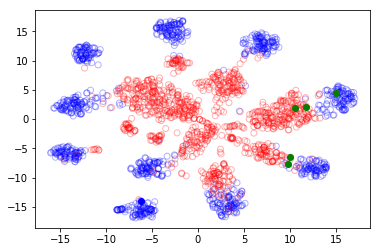

In [306]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(tsne_results[0:T,0], tsne_results[0:T,1], alpha=0.3,edgecolors='b',facecolors='none')
ax.scatter(tsne_results[T:, 0], tsne_results[T:, 1], alpha=0.3,edgecolors='r', facecolors='none')


for i in idxs_aa[0:1]:
    ax.scatter(tsne_results[i,0], tsne_results[i,1], color='b')
#for i in range(1000):
 #   if i not in idxs_bb:
  #      ax.scatter(tsne_results[i,0], tsne_results[i,1], color='b')

for i in idxs_bb[5:10]:
    ax.scatter(tsne_results[T+i,0], tsne_results[T+i,1], color='g')
#for i in range(1000):
    #if i not in idxs_bb:
        #ax.scatter(tsne_results[T+i,0], tsne_results[T+i,1], color='r')

In [199]:
#----------------- gmm for tsne ----------------------------------------------
gmm = mixture.GaussianMixture(n_components=10,covariance_type='full').fit(tsne_results[0:1000])
#-----------------------------------------------------------------------------

In [201]:
plot_results(tsne_results[0:1000], gmm.predict(tsne_results[0:1000]),gmm.means_, gmm.covariances_)
plt.scatter(tsne_results[1000:,0], tsne_results[1000:,1], alpha=0.3,edgecolors='r',facecolors='none')

In [248]:
pp = np.asanyarray(idxs_bb[5:10])+T
gmm.score_samples(tsne_results[pp])

array([-5.11933277, -9.90022805, -7.58325651, -7.71657976, -6.04851196])

In [222]:
aa_tsne = gmm.score_samples(tsne_results[:1000])
bb_tsne = gmm.score_samples(tsne_results[1000:])

[]

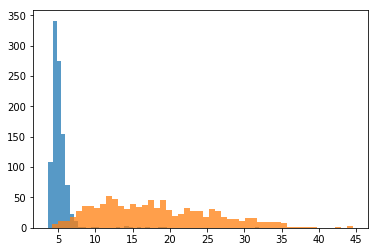

In [271]:
plt.hist(-1.*aa_tsne, bins=50, alpha=0.75)
plt.hist(-1.*bb_tsne, bins=50, alpha=0.75)
plt.plot()

In [273]:
tpr95_tsne(-1.*aa_tsne,-1.*bb_tsne)*100

6.552499999999999


3.030821917808219

In [308]:
tsne3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results3 = tsne3.fit_transform(x_train[0:2000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.035s...
[t-SNE] Computed neighbors for 2000 samples in 2.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.432056
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.024666
[t-SNE] KL divergence after 300 iterations: 1.077011


In [309]:
tsne4 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results4 = tsne4.fit_transform(data_ood[0:2000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.039s...
[t-SNE] Computed neighbors for 2000 samples in 3.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.014976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.694412
[t-SNE] KL divergence after 300 iterations: 1.503195


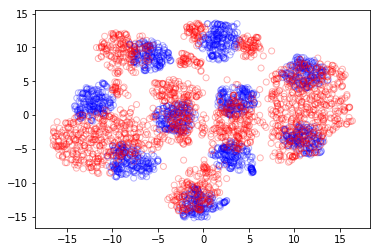

In [311]:
fig, ax = plt.subplots()
ax.scatter(tsne_results3[:,0], tsne_results3[:,1], alpha=0.3,edgecolors='b',facecolors='none')
ax.scatter(tsne_results4[:,0], tsne_results4[:,1], alpha=0.3,edgecolors='r', facecolors='none')

In [275]:
time_start = time.time()
time_start = time.time()
tsne2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results2 = tsne2.fit_transform(np.concatenate((x_train,data_ood), axis=0))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.627s...
[t-SNE] Computed neighbors for 20000 samples in 190.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

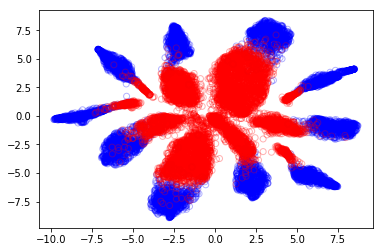

In [288]:
fig, ax = plt.subplots()
ax.scatter(tsne_results2[:10000,0], tsne_results2[:10000,1], alpha=0.3,edgecolors='b',facecolors='none')
ax.scatter(tsne_results2[10000:, 0], tsne_results2[10000:, 1], alpha=0.3,edgecolors='r', facecolors='none')

In [289]:
gmm2 = mixture.GaussianMixture(n_components=10,covariance_type='full').fit(tsne_results2[0:10000])

In [290]:
aa_tsne2 = gmm2.score_samples(tsne_results2[:10000])
bb_tsne2 = gmm2.score_samples(tsne_results2[10000:])

[]

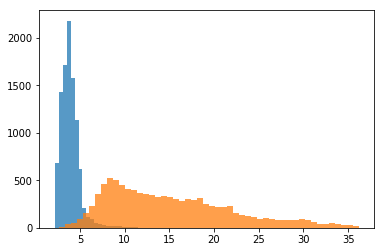

In [291]:
plt.hist(-1.*aa_tsne2, bins=50, alpha=0.75)
plt.hist(-1.*bb_tsne2, bins=50, alpha=0.75)
plt.plot()

In [292]:
tpr95_tsne(-1.*aa_tsne2,-1.*bb_tsne2)*100

5.5925


2.557880658436214

In [7]:
#%matplotlib tk

#fig1 = plt.figure(1)
#ax = fig1.add_subplot(111, projection='3d')
#ax.scatter(z_in[0:1000,0], z_in[0:1000,1], z_in[0:1000,2])
#ax.scatter(z_ood[0:1000, 0], z_ood[0:1000, 1], z_ood[0:1000,2], color='r')


fig2 = plt.figure(2)
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(tsne_results[9000:11000,0], tsne_results[9000:11000,1], tsne_results[9000:11000,2])
#ax.scatter(z_ood[0:1000, 0], z_ood[0:1000, 1], z_ood[0:1000,2], color='r')
plt.show()

(10000, 3)

In [ ]:


n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)